In [193]:
using DataFrames, Statistics, Plots, Measures

### Zadania
 
1.
 
2. Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

3.  Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

4. Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. **(1 pkt)**

5. Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**


### Zad1 
Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [194]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

In [195]:
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

In [196]:
# A*B

In [197]:
df = DataFrame(Nodes=Int[],Naive=Float64[],Better=Float64[], Lib = Float64[])
for n in 5:10:205
    A = rand(n, n);
    B = rand(n, n);
    for j in 1:11
        naive_AB, naive_t = @timed naive_multiplication(A,B)
        better_AB, better_t = @timed better_multiplication(A,B)
        lib_AB, lib_t = @timed A*B
        if j > 1
            push!(df,hcat([n],naive_t, better_t, lib_t))
        end
    end
end

In [198]:
df2 = combine(groupby(df, :Nodes), :Naive => mean, :Better => mean, :Lib => mean, :Naive => std, :Better => std, :Lib => std)
println(df2)

21×7 DataFrame
 Row │ Nodes  Naive_mean  Better_mean  Lib_mean    Naive_std    Better_std   Lib_std     
     │ Int64  Float64     Float64      Float64     Float64      Float64      Float64     
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │     5  2.6e-7       2.3e-7      3.1e-7      8.43274e-8   6.74949e-8   3.16228e-8
   2 │    15  5.83e-6      6.85e-6     8.2e-7      2.11082e-7   1.30538e-5   1.31656e-7
   3 │    25  3.281e-5     1.128e-5    2.82e-6     1.13183e-5   5.57375e-7   1.05809e-6
   4 │    35  8.304e-5     2.984e-5    8.56e-6     1.48264e-6   5.96657e-7   9.17027e-6
   5 │    45  0.00019574   6.965e-5    1.267e-5    1.33953e-5   1.69095e-5   2.21913e-6
   6 │    55  0.00036266   0.00011278  1.712e-5    3.5072e-6    2.89858e-6   2.30111e-6
   7 │    65  0.00075986   0.00021951  0.00025882  0.000176777  6.95141e-5   7.0605e-5
   8 │    75  0.00097418   0.00027768  0.00026699  1.39739e-5   6.30746e-6   4.77038e-5
   9 │    85

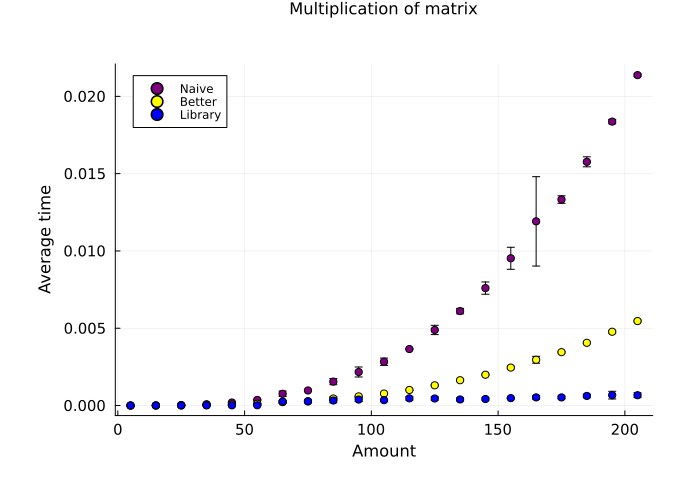

In [199]:
scatter(
    df2.Nodes, 
    size = (700, 500), 
    margin=10mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [df2.Naive_mean, df2.Better_mean, df2.Lib_mean], 
    title = "Multiplication of matrix", 
    label = ["Naive"  "Better" "Library"],
    color = [:purple :yellow :blue],
    yerr = [df2.Naive_std df2.Better_std df2.Lib_std], 
    legend = true
)